**Wine Quality – Spark ML & Pipelines**

In this notebook we:
- merge the red and white wine datasets into a single DataFrame,
- do some basic exploration (schema, summary stats) and a correlation matrix to get a first idea
  of how the chemical features relate to each other and to quality,
- build a regression pipeline with RandomForestRegressor to:
  - predict the numeric quality score from the chemical properties,
  - check how well this works using RMSE and R²,
  - see which features are the most important for the regression task,
- build a classification pipeline to predict whether a wine is “good” (for example, quality >= 7),
  where we train:
  - a shallow Decision Tree to get simple, human-readable decision rules,
  - a deeper Decision Tree to see what happens when we allow more complexity,
  - a Random Forest classifier to try to improve performance and stability over a single tree,
  - a Logistic Regression model as a simple linear baseline,
- compare all classification models using accuracy, F1-score and a confusion matrix,
- and finally, summarise:
  - how well wine quality can be predicted from these chemical features,
  - which variables seem to matter the most,
  - and which classification model is the most useful for the “good vs. not good” decision.

In [1]:
#1 imports

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import (
    DecisionTreeClassifier,
    RandomForestClassifier,
    LogisticRegression
)
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.stat import Correlation

from pyspark.ml.linalg import DenseMatrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🔧 Adjust JAVA_HOME to your environment if needed
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

spark = SparkSession.builder \
    .appName("WineQualityAnalysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/11 14:58:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
#2 loading data
red_path = "DATA/winequality-red.csv"
white_path = "DATA/winequality-white.csv"

red = spark.read.csv(red_path, header=True, inferSchema=True, sep=";") \
    .withColumn("type", when(col("quality").isNotNull(), "red"))

white = spark.read.csv(white_path, header=True, inferSchema=True, sep=";") \
    .withColumn("type", when(col("quality").isNotNull(), "white"))

wine = red.unionByName(white)

print("Number of rows:", wine.count())
wine.show(5)



Number of rows: 6497
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|type|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5| red|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5| red|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5| red|
|         11.2|            0.28|       0.56|     

In [3]:
#3 basic exploration -> O missig values

wine.printSchema()

from pyspark.sql.functions import col, when, count, isnan, lit

num_types = {"int", "bigint", "double", "float"}

missing = wine.select([
    count(
        when(
            # always check for NULL
            (col(c).isNull()) |
            # for numeric columns also check isnan(...)
            (isnan(col(c)) if t in num_types else lit(False)),
            c
        )
    ).alias(c)
    for c, t in wine.dtypes
])

print("Number of missing values per column:")
missing.show()


root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- type: string (nullable = true)

Number of missing values per column:
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|type|
+-------------+----------------+-----------+--------------+---------+-------------------+-----

In [4]:
#4 corealtion matrix and Vectorassembler
numeric_cols = [c for c, t in wine.dtypes if t in ("int", "double") and c != "quality"]

print("Columns used for correlation:", numeric_cols)

assembler_corr = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="features_corr"
)

wine_vec = assembler_corr.transform(wine).select("features_corr")

corr_matrix = Correlation.corr(wine_vec, "features_corr", "pearson").head()[0]
corr_matrix


Columns used for correlation: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


25/12/11 14:59:08 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


DenseMatrix(11, 11, [1.0, 0.219, 0.3244, -0.112, 0.2982, -0.2827, -0.3291, 0.4589, ..., -0.3594, -0.2569, -0.1798, -0.2657, -0.6867, 0.1212, -0.003, 1.0], False)

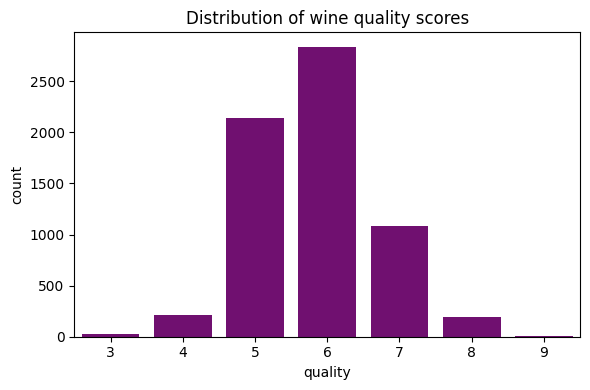

In [5]:
#6 PLOTS!

quality_pd = wine.select("quality").toPandas()

plt.figure(figsize=(6, 4))
sns.countplot(data=quality_pd, x="quality", color="purple")
plt.title("Distribution of wine quality scores")
plt.xlabel("quality")
plt.ylabel("count")
plt.tight_layout()
plt.show()



In [6]:
from pyspark.sql.functions import col

# we assume that 1 = good wine (quality >= 7), 0 = otherwise
wine_clf = wine.withColumn(
    "label",
    (col("quality") >= 7).cast("int")
)

wine_clf.select("quality", "label").show(10)




+-------+-----+
|quality|label|
+-------+-----+
|      5|    0|
|      5|    0|
|      5|    0|
|      6|    0|
|      5|    0|
|      5|    0|
|      5|    0|
|      7|    1|
|      7|    1|
|      5|    0|
+-------+-----+
only showing top 10 rows


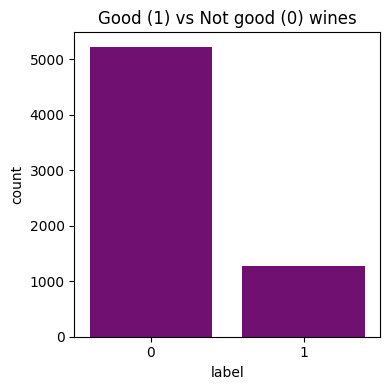

In [7]:
# distribution of the binary quality (0 = not good, 1 = good)

wine_pd = wine_clf.select("label").toPandas()

plt.figure(figsize=(4, 4))
sns.countplot(data=wine_pd, x="label", color="purple")
plt.title("Good (1) vs Not good (0) wines")
plt.xlabel("label")
plt.ylabel("count")
plt.tight_layout()
plt.show()



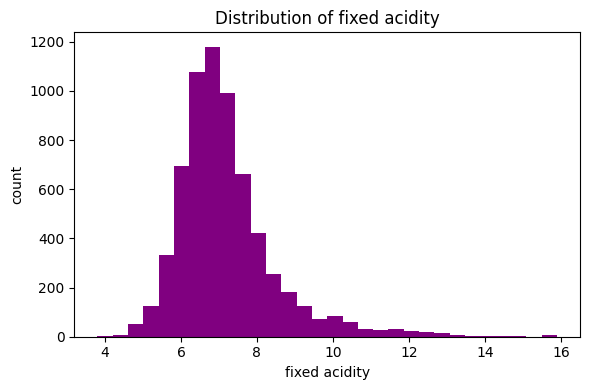

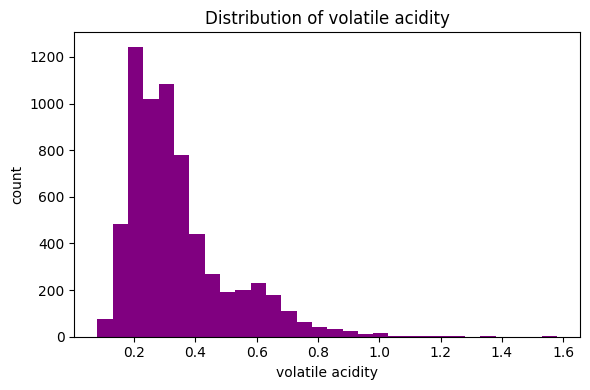

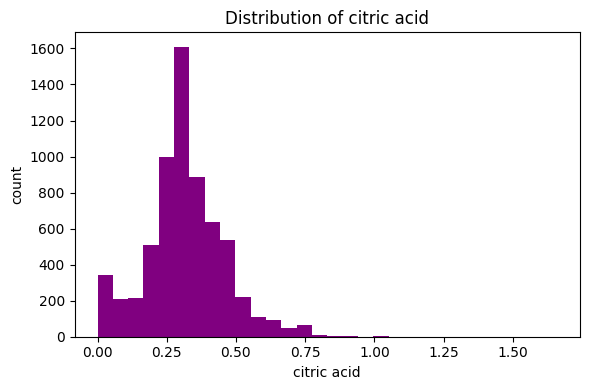

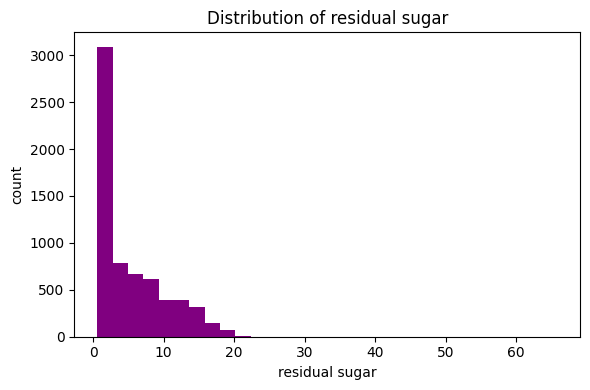

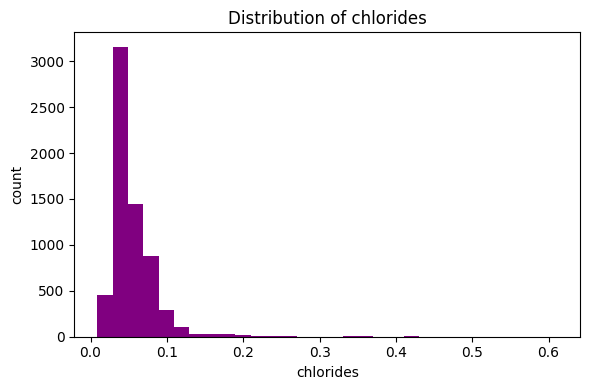

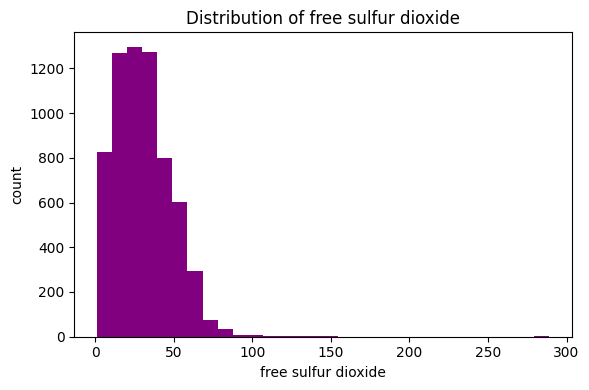

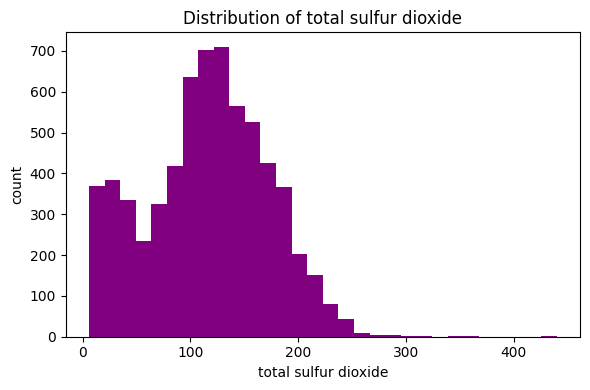

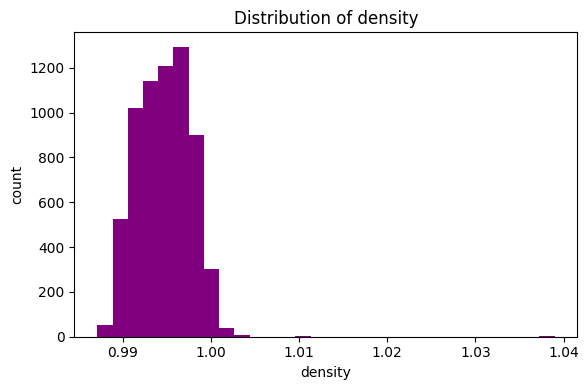

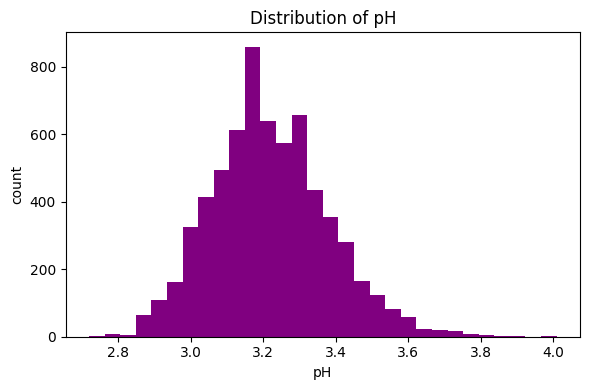

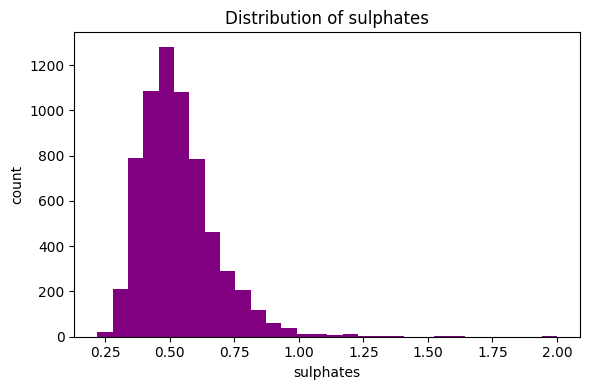

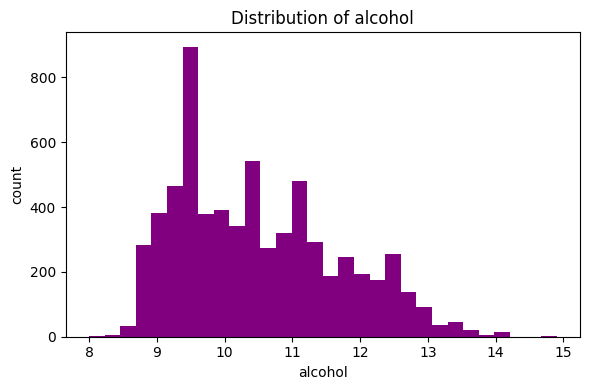

In [8]:
# Plots for all numeric columns (histograms)

numeric_cols = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol"
]

wine_pd_all = wine.select(numeric_cols + ["type"]).toPandas()

for col_name in numeric_cols:
    plt.figure(figsize=(6, 4))
    plt.hist(wine_pd_all[col_name], bins=30,color="purple")
    plt.title(f"Distribution of {col_name}")
    plt.xlabel(col_name)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()


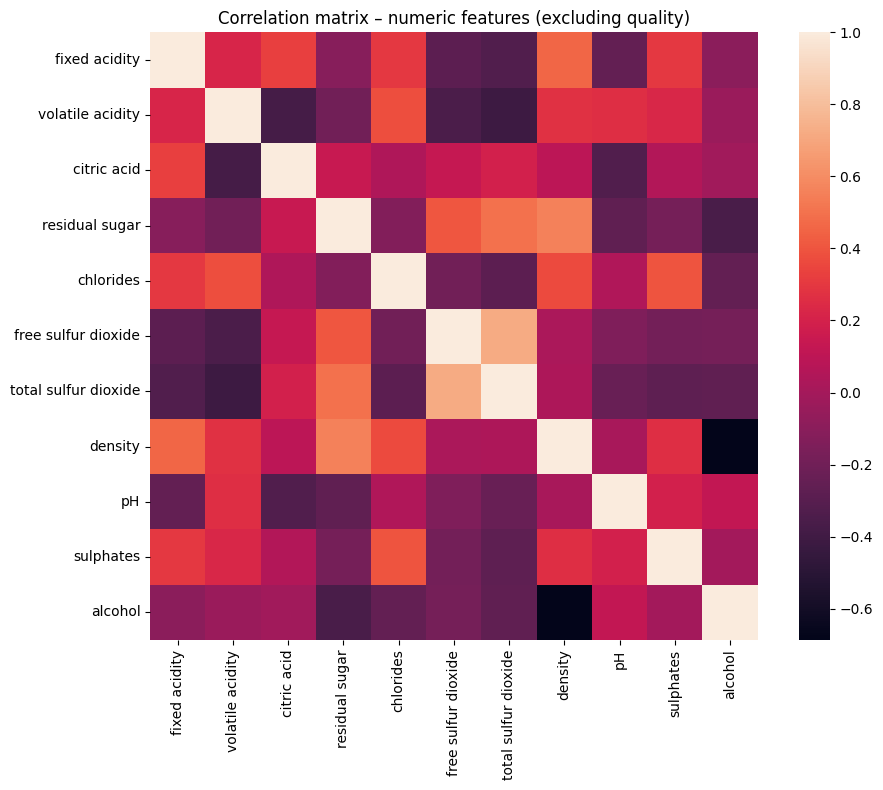

In [9]:
#6 visualisation - heatmap
corr_array = np.array(corr_matrix.toArray())
corr_df = pd.DataFrame(corr_array, index=numeric_cols, columns=numeric_cols)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=False, square=True)
plt.title("Correlation matrix – numeric features (excluding quality)")
plt.tight_layout()
plt.show()


- Higher alcohol content tends to be associated with higher quality.
- Lower density and lower volatile acidity often correlate with better quality.
- Some features (e.g. free and total sulfur dioxide) are strongly correlated with each other,
  which is important to keep in mind when interpreting feature importances


In [10]:
#7 regression pipeline (RandomForestRegressor), 100 trees, max deep =10 and 80/20, basing on the chemical features we are  forecasting quality of the wine

indexer = StringIndexer(inputCol="type", outputCol="type_indexed")

feature_cols_reg = [c for c in wine.columns if c not in ("quality", "type")]
assembler_reg = VectorAssembler(
    inputCols=feature_cols_reg,
    outputCol="features_assembled_reg"
)

scaler_reg = StandardScaler(
    inputCol="features_assembled_reg",
    outputCol="features_reg",
    withStd=True,
    withMean=False
)

rf_reg = RandomForestRegressor(
    labelCol="quality",
    featuresCol="features_reg",
    numTrees=100,
    maxDepth=10,
    seed=42
)

pipeline_reg = Pipeline(stages=[indexer, assembler_reg, scaler_reg, rf_reg])

train_reg, test_reg = wine.randomSplit([0.8, 0.2], seed=42)

model_reg = pipeline_reg.fit(train_reg)
pred_reg = model_reg.transform(test_reg)

pred_reg.select("quality", "prediction").show(10)


25/12/11 14:59:17 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
25/12/11 14:59:18 WARN DAGScheduler: Broadcasting large task binary with size 1864.4 KiB
25/12/11 14:59:19 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
25/12/11 14:59:20 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
25/12/11 14:59:21 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
25/12/11 14:59:22 WARN DAGScheduler: Broadcasting large task binary with size 1154.7 KiB


+-------+-----------------+
|quality|       prediction|
+-------+-----------------+
|      7|6.715389450942443|
|      6|6.056364743515655|
|      5|5.888101523576849|
|      5|5.213547879252729|
|      7|6.900427698571162|
|      7|6.164114980454243|
|      5| 5.21020340477364|
|      5|5.774954760139114|
|      6|6.096692287000499|
|      6| 5.68506485590416|
+-------+-----------------+
only showing top 10 rows


In [11]:
#8 evaluation of regression
evaluator_rmse = RegressionEvaluator(
    labelCol="quality",
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="quality",
    predictionCol="prediction",
    metricName="r2"
)

rmse = evaluator_rmse.evaluate(pred_reg)
r2 = evaluator_r2.evaluate(pred_reg)

print(f"RandomForestRegressor – RMSE: {rmse:.3f}")
print(f"RandomForestRegressor – R²:   {r2:.3f}")


RandomForestRegressor – RMSE: 0.647
RandomForestRegressor – R²:   0.447


RMSE: 0.647
The root mean squared error is 0.647. This is the average distance between the predicted and true quality scores. The lower this value, the better. Since wine quality scores are usually between 3 and 9, an RMSE of about 0.65 means the model is reasonably accurate, but of course not perfect.

R²: 0.447
The R² value of 0.447 means that the model explains about 44.7% of the variation in wine quality based on the chemical features. This is a moderate value. It suggests that chemistry does matter, but there are also other important factors not included in the dataset (e.g. region, vintage, tasting conditions, individual expert preferences), or that the model cannot fully capture all the complexity of the problem.

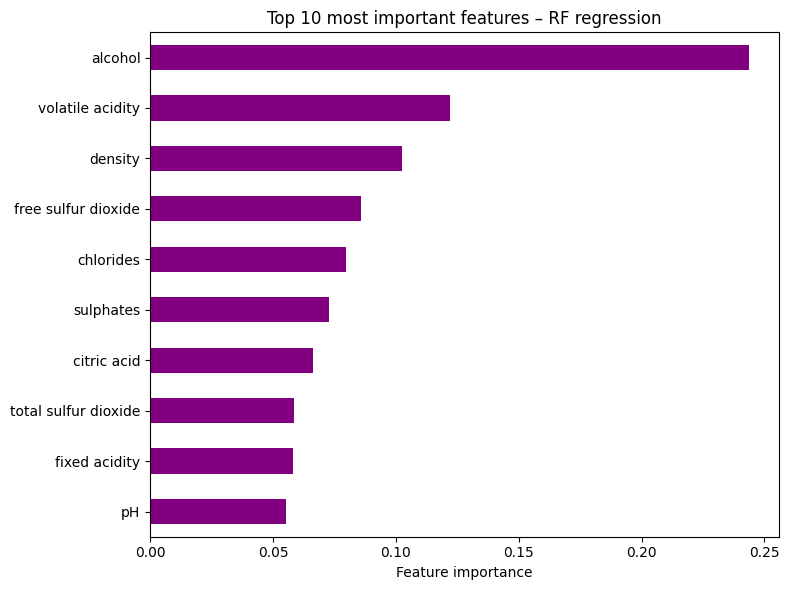

alcohol                 0.243828
volatile acidity        0.122234
density                 0.102679
free sulfur dioxide     0.085818
chlorides               0.079527
sulphates               0.072663
citric acid             0.066395
total sulfur dioxide    0.058658
fixed acidity           0.058180
pH                      0.055374
dtype: float64

In [12]:
#9 feature importance for regression
rf_reg_model = model_reg.stages[-1]

importances = rf_reg_model.featureImportances

feature_importances = pd.Series(
    importances.toArray(),
    index=feature_cols_reg
).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
feature_importances.head(10).plot(kind="barh", color="purple")
plt.gca().invert_yaxis()
plt.title("Top 10 most important features – RF regression")
plt.xlabel("Feature importance")
plt.tight_layout()
plt.show()

feature_importances.head(10)



alcohol (0.2438) –  the most important feature. Higher alcohol content is strongly associated with higher predicted wine quality. This is consistent with intuition and the earlier correlation analysis.

volatile acidity (0.1222) - second most important feature. Lower volatile acidity is typically linked to better-quality wines.

density (0.1027) – also important feature

In [13]:
#10 preparing data for classification ->clasyfiing wine into 2 categories 1 good 0 not good
from pyspark.sql.functions import col

#good wine is over 7 thats why we are creating label: 1 = good wine (quality >= 7), 0 = otherwise
wine_clf = wine.withColumn(
    "label",
    (col("quality") >= 7).cast("int")
)

wine_clf.select("quality", "label").show(10)

train_clf, test_clf = wine_clf.randomSplit([0.8, 0.2], seed=42)
print("Train:", train_clf.count(), "Test:", test_clf.count())


+-------+-----+
|quality|label|
+-------+-----+
|      5|    0|
|      5|    0|
|      5|    0|
|      6|    0|
|      5|    0|
|      5|    0|
|      5|    0|
|      7|    1|
|      7|    1|
|      5|    0|
+-------+-----+
only showing top 10 rows
Train: 5262 Test: 1235


In [14]:
#11 excluding quality,  label and 'type'
feature_cols_numeric_clf = [c for c in wine_clf.columns if c not in ("quality", "type", "label")]

indexer_clf = StringIndexer(inputCol="type", outputCol="type_indexed")


assembler_clf = VectorAssembler(
    inputCols=feature_cols_numeric_clf + [indexer_clf.getOutputCol()],
    outputCol="features_assembled_clf"
)

scaler_clf = StandardScaler(
    inputCol="features_assembled_clf",
    outputCol="features_clf",
    withStd=True,
    withMean=False
)

feature_cols_clf = feature_cols_numeric_clf + [indexer_clf.getOutputCol()]

In [15]:
#12 buliding 2 trees,  forest add logistic regression

# shallow decision tree - (less risk  of overfitting, more easy to interpret)
dt_shallow = DecisionTreeClassifier(
    labelCol="label",
    featuresCol="features_clf",
    maxDepth=3,
    seed=42
)

# deep decision tree (can overfit more easily!)
dt_deep = DecisionTreeClassifier(
    labelCol="label",
    featuresCol="features_clf",
    maxDepth=12,
    seed=42
)

# RF
rf_clf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features_clf",
    numTrees=100,
    maxDepth=10,
    seed=42
)

# Logistic regression
log_reg = LogisticRegression(
    labelCol="label",
    featuresCol="features_clf",
    maxIter=50,
    regParam=0.1,
    elasticNetParam=0.0
)

pipeline_dt_shallow = Pipeline(stages=[indexer_clf, assembler_clf, scaler_clf, dt_shallow])
pipeline_dt_deep    = Pipeline(stages=[indexer_clf, assembler_clf, scaler_clf, dt_deep])
pipeline_rf_clf     = Pipeline(stages=[indexer_clf, assembler_clf, scaler_clf, rf_clf])
pipeline_log_reg    = Pipeline(stages=[indexer_clf, assembler_clf, scaler_clf, log_reg])

In [16]:
#13 traning and comparing models
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

models = {
    "DecisionTree_shallow (maxDepth=3)": pipeline_dt_shallow,
    "DecisionTree_deep (maxDepth=12)": pipeline_dt_deep,
    "RandomForest (100 trees)": pipeline_rf_clf,
    "LogisticRegression": pipeline_log_reg
}

results = []

for name, pipeline in models.items():
    print(f"\n=== Model: {name} ===")
    model = pipeline.fit(train_clf)
    pred = model.transform(test_clf)

    acc = evaluator_acc.evaluate(pred)
    f1  = evaluator_f1.evaluate(pred)

    print(f"Accuracy: {acc:.3f}")
    print(f"F1-score: {f1:.3f}")

    results.append((name, acc, f1))

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1"])
results_df



=== Model: DecisionTree_shallow (maxDepth=3) ===


25/12/11 14:59:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Accuracy: 0.803
F1-score: 0.782

=== Model: DecisionTree_deep (maxDepth=12) ===
Accuracy: 0.824
F1-score: 0.827

=== Model: RandomForest (100 trees) ===


25/12/11 14:59:34 WARN DAGScheduler: Broadcasting large task binary with size 1598.4 KiB
25/12/11 14:59:35 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/12/11 14:59:36 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/12/11 14:59:37 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
25/12/11 14:59:39 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/12/11 14:59:39 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


Accuracy: 0.868
F1-score: 0.854

=== Model: LogisticRegression ===
Accuracy: 0.805
F1-score: 0.725


,Model,Accuracy,F1
0,DecisionTree_shallow (maxDepth=3),0.803239,0.781920
1,DecisionTree_deep (maxDepth=12),0.824291,0.826960
2,RandomForest (100 trees),0.868016,0.854450
3,LogisticRegression,0.804858,0.725292


RandomForest (100 trees) performs best – highest Accuracy (0.87) and F1 (0.85).

Deep decision tree is second – decent improvement over the shallow tree.

Shallow Decision Tree and Logistic Regression have similar Accuracy (0.80), but Logistic Regression has lower F1, so it handles the good class worse

In [17]:
#14 Retrain the best model on the full training data ->RF
best_model = pipeline_rf_clf.fit(train_clf)
pred_best = best_model.transform(test_clf)

pred_best.select("label", "prediction").show(10)


25/12/11 14:59:44 WARN DAGScheduler: Broadcasting large task binary with size 1598.4 KiB
25/12/11 14:59:45 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/12/11 14:59:46 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/12/11 14:59:47 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows


25/12/11 14:59:49 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


25/12/11 15:03:26 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


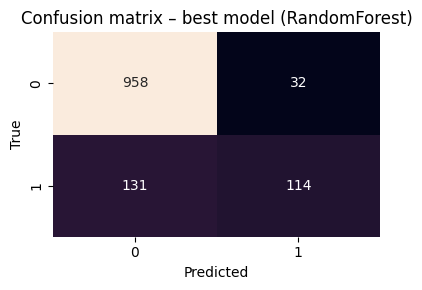

Confusion matrix (RF):
[[958  32]
 [131 114]]


In [24]:
#15 generating confusion matrix to evaluate the RF
from sklearn.metrics import confusion_matrix

y_true = np.array(pred_best.select("label").toPandas()["label"])
y_pred = np.array(pred_best.select("prediction").toPandas()["prediction"])

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix – best model (RandomForest)")
plt.tight_layout()
plt.show()

print("Confusion matrix (RF):")
print(cm)



The confusion matrix suggests that the Random Forest model handles the “not good” wines much better than the “good” ones. It rarely marks a bad wine as good, but quite often fails to recognise good wines and classifies them as not good. In other words, the model is quite conservative – it prefers to be strict when giving the “good” label, which leads to lower recall for that class.

In [19]:
#Insights form decision tree - as in comparison to RF they are easier to interpret
numeric_features_for_tree = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol"
]

cols_for_sklearn = numeric_features_for_tree + ["label"]

wine_sklearn_pd = wine_clf.select(cols_for_sklearn).toPandas()

X = wine_sklearn_pd[numeric_features_for_tree]
y = wine_sklearn_pd["label"]

X.head(), y.head()



(   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
 0            7.4              0.70         0.00             1.9      0.076   
 1            7.8              0.88         0.00             2.6      0.098   
 2            7.8              0.76         0.04             2.3      0.092   
 3           11.2              0.28         0.56             1.9      0.075   
 4            7.4              0.70         0.00             1.9      0.076   
 
    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
 0                 11.0                  34.0   0.9978  3.51       0.56   
 1                 25.0                  67.0   0.9968  3.20       0.68   
 2                 15.0                  54.0   0.9970  3.26       0.65   
 3                 17.0                  60.0   0.9980  3.16       0.58   
 4                 11.0                  34.0   0.9978  3.51       0.56   
 
    alcohol  
 0      9.4  
 1      9.8  
 2      9.8  
 3      9.8  
 4

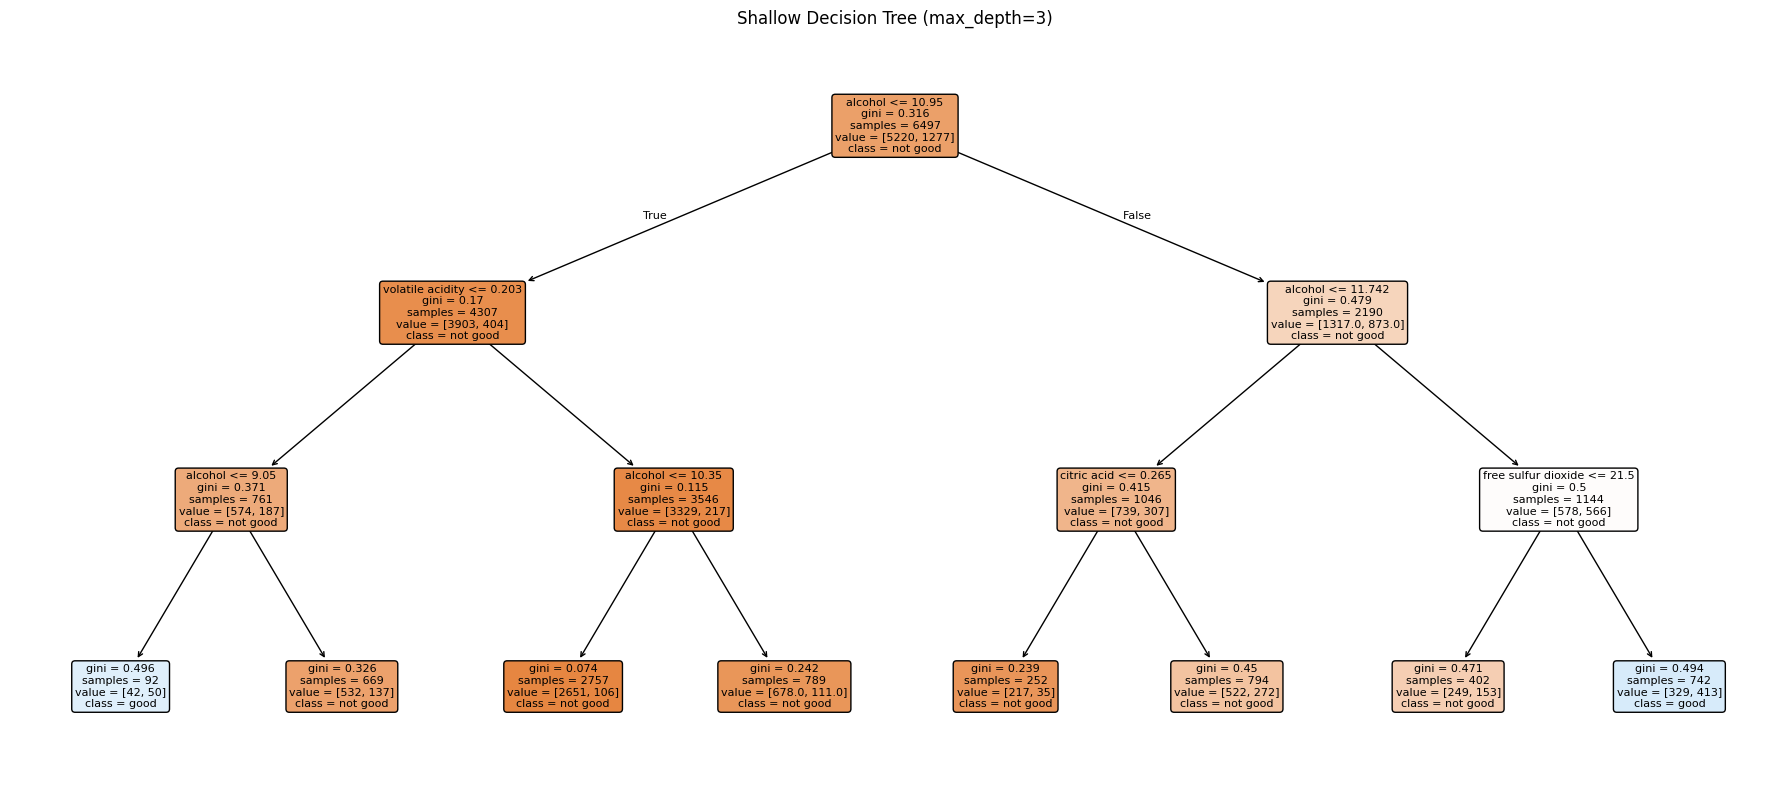

In [20]:
from sklearn.tree import DecisionTreeClassifier as SkDecisionTreeClassifier
from sklearn import tree

dt_shallow_sklearn = SkDecisionTreeClassifier(
    max_depth=3,
    random_state=42
)

dt_shallow_sklearn.fit(X, y)

plt.figure(figsize=(18, 8))
tree.plot_tree(
    dt_shallow_sklearn,
    feature_names=numeric_features_for_tree,
    class_names=["not good", "good"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Shallow Decision Tree (max_depth=3)")
plt.tight_layout()
plt.show()


The shallow decision tree shows that alcohol is the main factor for predicting wine quality. The first splits are all based on alcohol level, so higher or lower alcohol is the key separation between “good” and “not good” wines.

On the low-alcohol side (≤ 10.95), most wines are classified as not good. Only a small region with very low volatile acidity gets classified as good, and even there the leaf is quite mixed (both good and not good wines).

On the high-alcohol side (> 10.95), the tree still uses alcohol plus a few extra features, mainly citric acid and free sulfur dioxide. One of the main “good wine” leaves appears when alcohol is high (≈ > 11.7) and free sulfur dioxide is above about 21.5.

Overall, the tree suggests:

higher alcohol -> more chance of a good wine

low volatile acidity helps especially for lower-alcohol wines

free sulfur dioxide and citric acid also play a role, but are secondary


"GOOD"

leaf no.1 condition 
alcohol <= 10.95
volatile acidity <= 0.203
alcohol <= 9.05

leaf no.2 condition
alcohol > 10.95 
alcohol > 11.742
free sulfur dioxide > 21.5


In [21]:
# 16 deep learning model

from pyspark.ml.classification import MultilayerPerceptronClassifier


input_size = len(feature_cols_clf)
output_size = 2 

# 3 layer: input -> 16 -> 8 -> 2
layers = [input_size, 16, 8, output_size]

mlp_clf = MultilayerPerceptronClassifier(
    labelCol="label",
    featuresCol="features_clf",
    maxIter=100,
    layers=layers,
    blockSize=128,
    seed=42
)

pipeline_mlp = Pipeline(stages=[indexer_clf, assembler_clf, scaler_clf, mlp_clf])

mlp_model = pipeline_mlp.fit(train_clf)
pred_mlp = mlp_model.transform(test_clf)


acc_mlp = evaluator_acc.evaluate(pred_mlp)
f1_mlp  = evaluator_f1.evaluate(pred_mlp)

print("=== MultilayerPerceptronClassifier (deep learning) ===")
print(f"Accuracy: {acc_mlp:.3f}")
print(f"F1-score: {f1_mlp:.3f}")


=== MultilayerPerceptronClassifier (deep learning) ===
Accuracy: 0.813
F1-score: 0.786


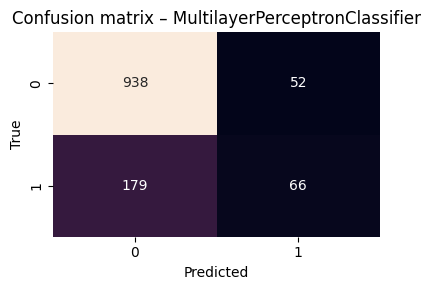

Confusion matrix (MLP):
[[938  52]
 [179  66]]


In [25]:
# 17 confusion matrix for the deep learning model 

from sklearn.metrics import confusion_matrix

y_true_dl = np.array(pred_mlp.select("label").toPandas()["label"])
y_pred_dl = np.array(pred_mlp.select("prediction").toPandas()["prediction"])

cm_dl = confusion_matrix(y_true_dl, y_pred_dl)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_dl, annot=True, fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix – MultilayerPerceptronClassifier")
plt.tight_layout()
plt.show()

print("Confusion matrix (MLP):")
print(cm_dl)

